# AutoEncoder


Autoencoder 是一種無監督 (unsupervised) 的訓練方式，也就是說在訓練的時候是不需要給定目標的，那它是怎麼做到的呢？

在 Hinton 的開山 [paper]( [Reducing the Dimensionality of Data with Neural Networks](https://www.cs.toronto.edu/~hinton/science.pdf)) ．它的概念可以從以下的圖來說明．可以看到有兩個部分 **Encoder** 以及 **Decoder**，而中間有一個重疊的 **code layer**．模型輸入是從 Encoder 輸入，輸出則是 Decoder 輸出．而 Encoder 中有許多的 hidden layer (隱層)，其中節點數量是遞減的；相對應的 Decoder 則是遞增的．

在這樣對稱的網路結構中，給定的訓練條件是輸出越接近輸入越好，
$$
x : input of network \\
\hat{x} : output of network \\
h(x) : hidden layer function \\
x \equiv \hat{x} = h(x)
$$


![](http://imgur.com/WnzC82f.jpg) 

圖片來自 Hinton 的 paper [Reducing the Dimensionality of Data with Neural Networks](https://www.cs.toronto.edu/~hinton/science.pdf)

訓練的過程用 `backpropagation` 即可，而當訓練完成以後，我們把 Decoder 移除，只剩下 Encoder (包含 Code layer)．

## 無監督學習

很有趣的如果只剩下 Encoder，可以看到它有很類似 `PCA` 的 `Dimension Reduction` 效果．因為 2000 維輸入變成了 30 維．不同的是它是一個非線性的降維方法取出了原始輸入的必要特徵．

來看看取出的特徵和 `PCA` 的做對照：

第一列為原始圖片

第二列為 Autoencoder 降維結果

第三列為 PCA 降維結果

![](http://imgur.com/9QNBD27.jpg)

圖片來自 Hinton 的 paper [Reducing the Dimensionality of Data with Neural Networks](https://www.cs.toronto.edu/~hinton/science.pdf)

可以看到 `Autoencoder` 的效果比 `PCA` 來得好．

那如果用 MNIST 的資料投影到二維的視覺化圖形來看，左邊是 `PCA`，右邊是 `Autoencoder`，也可以看到它比較成功的輸入依據特徵不同做分類．但這段過程都是無監督的情下完成的，也可以說是 

> **它自動地學會了如何區分每個手寫數字**

![](http://imgur.com/VX4oeSa.jpg)

而在實用的時候，網路的最後面會接一個 softmax 之類的分類器，因為理論上已經找出了輸入的特徵，這時候加上分類器，才是人類真正告訴它你分類出的結果是什麼．

## 實作 Autoencoder

In [ ]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

In [2]:
def weight_variable(shape, name):
    return tf.Variable(tf.truncated_normal(shape = shape, stddev = 0.1), name)
def bias_variable(shape, name):
    return tf.Variable(tf.constant(0.1, shape = shape), name)

初步的構想是建立一個七層的神經網路，在 encoder 維度會從 784 逐步變成 300, 100, 5 (code layer)， decoder 的時候再逐步轉回 100, 300, 784．而這個想法在現在對 tensorflow 比較熟悉的情形下是很容易實現的，以下就是我實現的程式碼片段

**input -> 784 -> 300 -> 100 -> 5 (code layer) -> 100 -> 300 -> 784 -> output**

In [3]:
x = tf.placeholder(tf.float32, shape = [None, 784])
e_W_1 = weight_variable([784, 300], "e_W_1")
e_b_1 = bias_variable([300], "e_b_1")
e_layer1 = tf.nn.relu(tf.matmul(x, e_W_1) + e_b_1)
e_W_2 = weight_variable([300, 100], "e_W_2")
e_b_2 = bias_variable([100], "e_b_2")
e_layer2 = tf.nn.relu(tf.matmul(e_layer1, e_W_2) + e_b_2)
e_W_3 = weight_variable([100, 20], "e_W_3")
e_b_3 = bias_variable([20], "e_b_3")
code_layer = tf.nn.relu(tf.matmul(e_layer2, e_W_3) + e_b_3)
d_W_1 = weight_variable([20, 100], "d_W_1")
d_b_1 = bias_variable([100], "d_b_1")
d_layer1 = tf.nn.relu(tf.matmul(code_layer, d_W_1) + d_b_1)
d_W_2 = weight_variable([100, 300], "d_W_2")
d_b_2 = bias_variable([300], "d_b_2")
d_layer2 = tf.nn.relu(tf.matmul(d_layer1, d_W_2) + d_b_2)
d_W_3 = weight_variable([300, 784], "d_W_3")
d_b_3 = bias_variable([784], "d_b_3")
output_layer = tf.nn.relu(tf.matmul(d_layer2, d_W_3) + d_b_3)

loss 函數我使用了 `mean square error`，而 optimizer 原本是使用 `GradientDescentOptimizer`，但是做出來的 decode 結果變得非常糟糕 (如下)．後來上網搜尋了以後改用 `RMSPropOptimizer`，以下會隨機選出五個數字來看看所做出來的結果．

In [4]:
loss = tf.reduce_mean(tf.pow(output_layer - x, 2))
optimizer = tf.train.RMSPropOptimizer(0.01).minimize(loss)
init_op = tf.global_variables_initializer()

In [5]:
sess = tf.InteractiveSession()
sess.run(init_op)
for i in range(10000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        print("step %d, loss %g"%(i, loss.eval(feed_dict={x:batch[0]})))
    optimizer.run(feed_dict={x: batch[0]})
    
print("final loss %g" % loss.eval(feed_dict={x: mnist.test.images}))

step 0, loss 0.154249
step 100, loss 0.0938953
step 200, loss 0.0631583
step 300, loss 0.0638728
step 400, loss 0.0447373
step 500, loss 0.0425786
step 600, loss 0.0370292
step 700, loss 0.0394285
step 800, loss 0.0413142
step 900, loss 0.0367071
step 1000, loss 0.0392272
step 1100, loss 0.0350341
step 1200, loss 0.036414
step 1300, loss 0.0374863
step 1400, loss 0.0331814
step 1500, loss 0.0381974
step 1600, loss 0.0351127
step 1700, loss 0.0374433
step 1800, loss 0.0347769
step 1900, loss 0.0375457
step 2000, loss 0.0378837
step 2100, loss 0.0406829
step 2200, loss 0.0348483
step 2300, loss 0.0344163
step 2400, loss 0.0335558
step 2500, loss 0.0333809
step 2600, loss 0.030228
step 2700, loss 0.0333538
step 2800, loss 0.0300326
step 2900, loss 0.0313007
step 3000, loss 0.0325943
step 3100, loss 0.0291298
step 3200, loss 0.029259
step 3300, loss 0.029667
step 3400, loss 0.0284405
step 3500, loss 0.0336205
step 3600, loss 0.0346183
step 3700, loss 0.0361299
step 3800, loss 0.036426
step

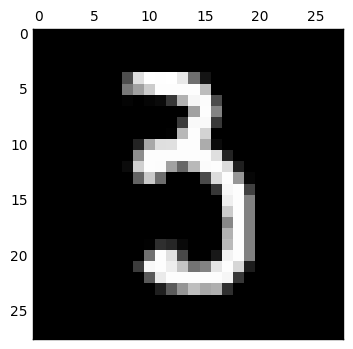

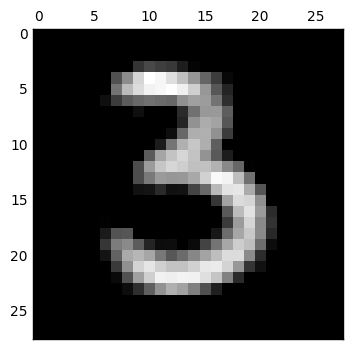

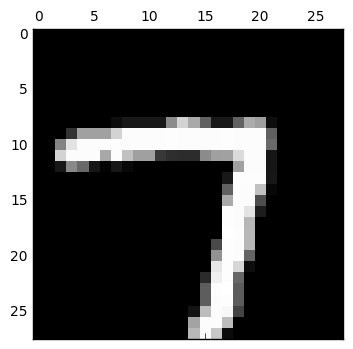

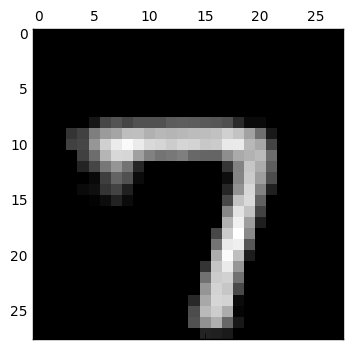

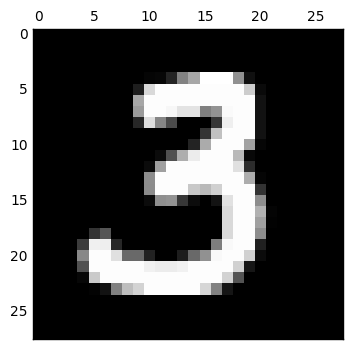

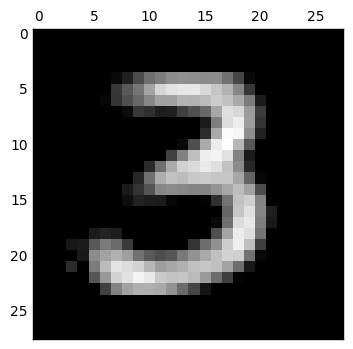

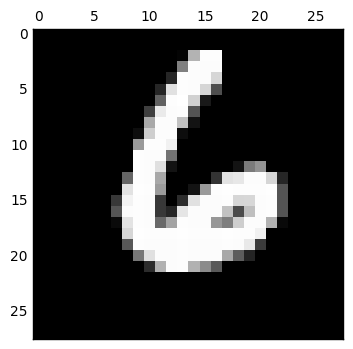

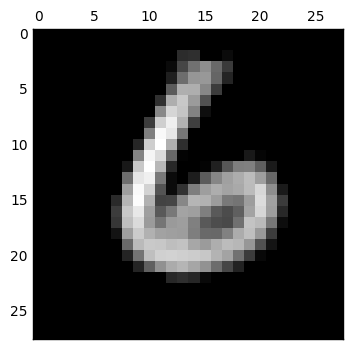

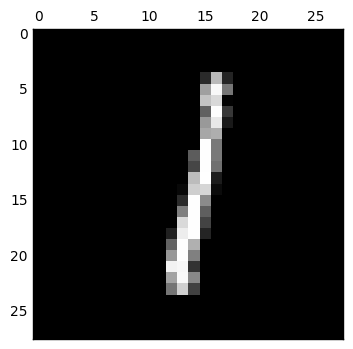

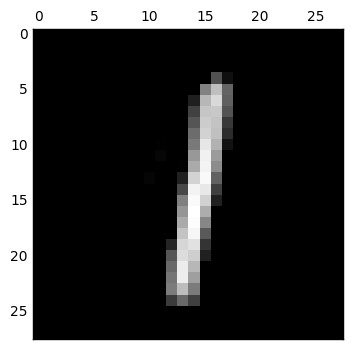

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
trainimg = mnist.train.images
trainlabel = mnist.train.labels
output_nd = output_layer.eval(feed_dict = {x: mnist.train.images})
for i in [0, 1, 2, 3, 4]:
    curr_img   = np.reshape(trainimg[i, :], (28, 28)) # 28 by 28 matrix 
    ae_img = np.reshape(output_nd[i,:], (28, 28))
    curr_label = np.argmax(trainlabel[i, :] ) # Label
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
    plt.matshow(ae_img, cmap=plt.get_cmap('gray'))

而接下來當我想嘗試把 code layer 的維度調整為 2 維來看看
## 今日心得
而接下來當我想嘗試把 code layer 的維度調整為 2 維來看看

![](http://imgur.com/1n9Ljnb.jpg)

![](http://imgur.com/cmzYYOS.jpg)

![](http://imgur.com/ICUGyPC.jpg)

![](http://imgur.com/VpnycII.jpg)

我們可以發現完全糊掉了，只用二維來表示輸入數字是不太夠的．更進一步仔細看 code layer 的值，都已經接近零，表示這個網路已經算是死掉了．

In [10]:
def plot_scatter(x, labels, title, txt = False):
    plt.title(title)
    ax = plt.subplot()
    ax.scatter(x[:,0], x[:,1], c = labels)
    txts = []
    if txt:
        for i in range(10):
            xtext, ytext = np.median(x[labels == i, :], axis=0)
            txt = ax.text(xtext, ytext, str(i), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
            txts.append(txt)
    plt.show()